In [3]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import Qobj
from qutip.metrics import dnorm
from qutip.superop_reps import to_super
from qutip.superop_reps import to_super, super_to_choi
from scipy.linalg import expm
from toqito.channel_metrics import diamond_norm

In [4]:
x = np.array([[0, 1], [1, 0]])
y = np.array([[0, -1j], [1j, 0]])
z = np.array([[1, 0], [0, -1]])
i = np.array([[1, 0], [0, 1]])

X1 = np.kron(x, i)
X2 = np.kron(i, x)
Y1 = np.kron(y, i)
Y2 = np.kron(i, y)
Z1 = np.kron(z, i)
Z2 = np.kron(i, z)
I = np.kron(i, i)

sP= np.array([[0, 1], [0, 0]])
sM = np.array([[0, 0], [1, 0]])
sP1 = np.kron(sP, i)
sM1 = np.kron(sM, i)
sP2 = np.kron(i, sP)
sM2 = np.kron(i, sM)

In [5]:
def H_xx(J: float):
    return J * (X1 @ X2)

def H_yy(J: float):
    return J * (Y1 @ Y2)

def H(J: float):
    return H_xx(J) + H_yy(J)

def vec(op1, op2):
    return np.kron(op2.T, op1)

def vec_com(op):
    return vec(op, I) - vec(I, op)

def D1(Γ: float):
    return Γ * ( vec(sP1, sM1) - 0.5 * vec(sM1 @ sP1, I) - 0.5 * vec(I, sM1 @ sP1) )

def D2(Γ: float):
    return Γ * ( vec(sP2, sM2) - 0.5 * vec(sM2 @ sP2, I) - 0.5 * vec(I, sM2 @ sP2) ) 

def L(J: float, Γ: float):
    return -1j * vec_com(H(J)) + D1(Γ) + D2(Γ)

def e_Lxx(J: float):
    return expm(-1j * vec_com(H_xx(J)))

def e_Lyy(J: float):
    return expm(-1j * vec_com(H_yy(J)))

def e_D1(Γ: float):
    return expm(D1(Γ))

def e_D2(Γ: float):
    return expm(D2(Γ))

def e_L(J: float, Γ: float):
    return expm(-1j * L(J, Γ))

In [6]:
def trotter_steps(J: float, Γ: float, t: float = 1, ε: float = 0.01):
    """Compute the minimum number of trotter steps required."""
    lindbladians = [
        e_Lxx(J),
        e_Lyy(J),
        e_D1(Γ),
        e_D2(Γ),
    ]
    m = len(lindbladians)
    max_diamond_norm = max(dnorm(Qobj(Li)) for Li in lindbladians)
    return (4 * (m * t * max_diamond_norm) ** (3 / 2)) / np.sqrt(ε)

Text(0, 0.5, 'Trotter steps')

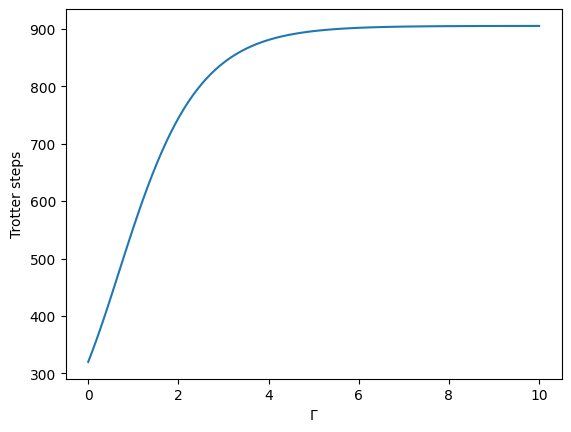

In [7]:
Γs = np.linspace(0, 10, 100)
steps = [trotter_steps(J=1, Γ=Γ, t=1, ε=0.01) for Γ in Γs]
plt.plot(Γs, steps)
plt.xlabel("Γ")
plt.ylabel("Trotter steps")

In [8]:
def trotterize(J: float, Γ: float, trotter_steps: int):
    """Compute a Trotter approximation of e^{Lt}."""
    superXX = vec_com(J * X1 @ X2)
    superYY = vec_com(J * Y1 @ Y2)

    eXX = expm(-1j * superXX / (2 * trotter_steps))
    eYY = expm(-1j * superYY / (2 * trotter_steps))
    eD1 = expm(D1(Γ) / (2 * trotter_steps))
    eD2 = expm(D2(Γ) / (2 * trotter_steps))

    step = eXX @ eYY @ eD1 @ eD2 @ eD2 @ eD1 @ eYY @ eXX
    return np.linalg.matrix_power(step, trotter_steps)

def hilbert_schmidt_distance(J: float, Γ: float, trotter_steps: int):
    """Check the Hilbert-Schmidt distance between e^{Lt} and the Trotterized approximation."""
    appx_eL = trotterize(J, Γ, trotter_steps)
    real_eL = expm(L(J, Γ))
    diff = real_eL - appx_eL
    return np.real(np.trace(diff.conj().T @ diff))

def diamond_distance(J: float, Γ: float, trotter_steps: int):
    """Check the diamond distance between e^{Lt} and the Trotterized approximation."""
    appx_eL = trotterize(J, Γ, trotter_steps)
    real_eL = expm(L(J, Γ))
    real_el_choi = super_to_choi(to_super(Qobj(real_eL)))
    appx_el_choi = super_to_choi(to_super(Qobj(appx_eL)))
    return diamond_norm(np.array(real_el_choi), np.array(appx_el_choi))

In [9]:
steps = np.arange(1, 20)
hs_dists = [hilbert_schmidt_distance(J=1, Γ=1, trotter_steps=s) for s in steps]
diamond_dists = [diamond_distance(J=1, Γ=1, trotter_steps=s) for s in steps]

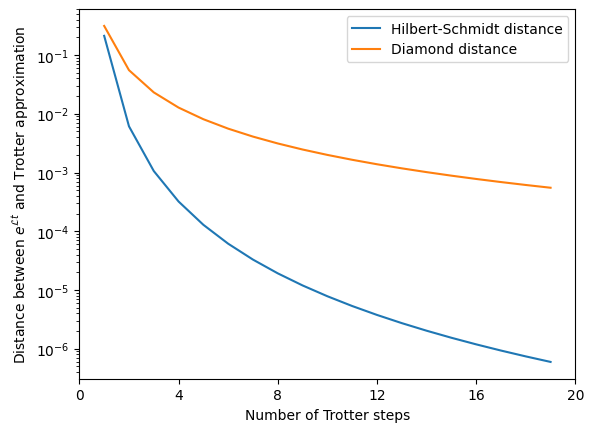

In [19]:
plt.plot(steps, hs_dists, label="Hilbert-Schmidt distance")
plt.plot(steps, diamond_dists, label="Diamond distance")
plt.xlabel("Number of Trotter steps")
plt.ylabel(r"Distance between $e^{\mathcal{L}t}$ and Trotter approximation")
plt.yscale("log")
plt.xticks(range(0,21,4))
plt.legend()